In [96]:
import numpy as np
import sympy
import random
import math
import matplotlib.pyplot as plt
from sympy import *
import scipy
from scipy.stats import chi2  

np.random.seed(16)
# n = 500
n = 50
p = 1
x =  np.random.random((n,p))
xte = 5*np.ones((1,1))

NOISE = 1

noise =  np.random.normal(0,NOISE,n).reshape(-1,1)
noisete = np.random.normal(0,NOISE)

theta0 = 1

yte = np.dot(xte,theta0) + noisete    
y = np.dot(x,theta0) + noise

theta_min = -2.5
theta_max = 4.5
grid_num = 1001
thetagrid = np.linspace(theta_min, theta_max, grid_num)

def L2(theta,x,y):
    s = np.linalg.norm(y - np.dot(x,theta),ord=2)
    return s


In [97]:
# classical intervals
thetaols = np.dot(np.dot(np.linalg.inv(np.dot(x.T,x)),x.T),y)
theta_u_cl = float(thetaols + sqrt(float(np.linalg.inv(np.dot(x.T,x)))) * L2(thetaols,x,y) * sqrt(scipy.stats.f.ppf( .95,1,n-1)) / sqrt(n-p))
theta_l_cl = float(thetaols - sqrt(float(np.linalg.inv(np.dot(x.T,x)))) * L2(thetaols,x,y) * sqrt(scipy.stats.f.ppf( .95,1,n-1)) / sqrt(n-p))
print(thetaols)

temp = np.linalg.inv(np.dot(x.T,x))
temp1 = np.dot(xte,temp)
temp1 = np.dot(temp1,xte)

y_pred_u_cl = float(np.dot(xte,thetaols) + L2(thetaols,x,y) * sqrt(scipy.stats.f.ppf( .95,1,n-p)) * sqrt(float(1 + temp1)) * sqrt(1/(n-p)))
y_pred_l_cl = float(np.dot(xte,thetaols) - L2(thetaols,x,y) * sqrt(scipy.stats.f.ppf( .95,1,n-p)) * sqrt(float(1 + temp1)) * sqrt(1/(n-p)))

print(y_pred_l_cl,y_pred_u_cl)

[[1.2465498]]
3.092123206633212 9.373374840833524


In [98]:
# gaussian pivotal
pred_cl_u = np.dot(xte,thetagrid.reshape(1,-1)) + L2(thetaols,x,y) * sqrt(scipy.stats.f.ppf( .90,1,n-1)) * sqrt(1/(n-1))
pred_cl_l = np.dot(xte,thetagrid.reshape(1,-1)) - L2(thetaols,x,y) * sqrt(scipy.stats.f.ppf( .90,1,n-1)) * sqrt(1/(n-1))
pred_cl_u = pred_cl_u.reshape(-1,1)
pred_cl_l = pred_cl_l.reshape(-1,1)

In [99]:
# cyclic-shift based
K = n
alpha = 0.1
alpha1 = int((K+1) * alpha /2)
alpha2 = K + 1 - alpha1
pred_cb_u = np.linspace(theta_min, theta_max, grid_num)
pred_cb_l = np.linspace(theta_min, theta_max, grid_num)
for i in range(len(thetagrid)):
    res = y - thetagrid[i] * x
    temp = np.sort(res,axis=0)
    pred_cb_l[i] = np.dot(xte,thetagrid[i]) + temp[alpha1 - 1] 
    pred_cb_u[i] = np.dot(xte,thetagrid[i]) + temp[alpha2 - 1] 

In [100]:
# optimal prediction component    
pred_ot_l = np.dot(xte,thetagrid.reshape(1,-1))+ scipy.stats.norm.ppf( .05,0,1)
pred_ot_u = np.dot(xte,thetagrid.reshape(1,-1))+ scipy.stats.norm.ppf( .95,0,1)
pred_ot_l = pred_ot_l.flatten()
pred_ot_u = pred_ot_u.flatten()

In [101]:
# permutation-based JCR
pred_pb_u = np.linspace(theta_min, theta_max, grid_num)
pred_pb_l = np.linspace(theta_min, theta_max, grid_num)

pred_pb_u_1 = np.linspace(theta_min, theta_max, grid_num)
pred_pb_l_1 = np.linspace(theta_min, theta_max, grid_num)

# number of permutation group
K = 500    
alpha = 0.1

permutation = []
for i in range(K):
    A = np.zeros((n+1,1))
    for i in range(n+1):
        A[i] = i
    np.random.shuffle(A)
    while(A[n]==n):
        np.random.shuffle(A)
    permutation.append(A)

permutation_matrix = []
for i in range(K):
    M = np.zeros((n+1,n+1))
    A = permutation[i]
    for j in range(n+1):
        M[int(A[j]),j]=1
    permutation_matrix.append(M)
    
x1 = np.concatenate([x,xte])
x1_n = x1 - np.mean(x1)*np.ones((n+1,1))

thetagrid = np.linspace(theta_min, theta_max, grid_num)
for i in range(len(thetagrid)):
    res = y - thetagrid[i] * x
    yte_temp = np.dot(np.mean(x1),thetagrid[i]) * np.ones((1,1))
    y1 = np.concatenate([y,yte_temp])
    res1 = y1 - thetagrid[i] * x1
    res1_n = res1 - np.mean(res1)*np.ones((n+1,1))
    sum1 = np.dot(x1_n.T,res1_n)
    
    temp1 = []
    temp2 = []
    for j in range(K):
        sum2 = np.dot(np.dot(permutation_matrix[j],x1_n).T,res1_n)
        idx = int(permutation[j][n])
        #intersection
        bound1 = (sum2-sum1)/float((xte-x1[idx]))
        bound2 = (sum2+sum1)/float(2*np.mean(x1)-xte-x1[idx])
        if (float(xte-np.mean(x1))*bound1+sum1)<0:
            temp1.append(yte_temp + bound1)
            temp2.append(yte_temp + bound2)
        else:
            temp1.append(yte_temp + bound2)
            temp2.append(yte_temp + bound1)
    temp1 = np.sort(temp1,axis=0)
    temp2 = np.sort(temp2,axis=0)
    pred_pb_l[i] = temp1[int(alpha*K)-1] 
    pred_pb_u[i] = temp2[K - int(alpha*K)]  
    pred_pb_l_1[i] = temp1[int(0.5*alpha*K)-1]
    pred_pb_u_1[i] = temp2[K - int(0.5*alpha*K)]

In [102]:
#intersect
K = n
alpha = 0.1
alpha1 = int((K+1) * alpha /2)
alpha2 = K + 1 - alpha1
thetagrid1 = np.linspace(theta_l_cl, theta_u_cl, grid_num)
intersect_u = np.linspace(theta_l_cl, theta_u_cl, grid_num)
intersect_l = np.linspace(theta_l_cl, theta_u_cl, grid_num)

for i in range(len(intersect_u)):
    res = y - thetagrid1[i] * x
    temp = np.sort(res,axis=0)
    intersect_l[i] = np.dot(xte,thetagrid1[i]) + temp[alpha1 - 1] 
    intersect_u[i] = np.dot(xte,thetagrid1[i]) + temp[alpha2 - 1] 

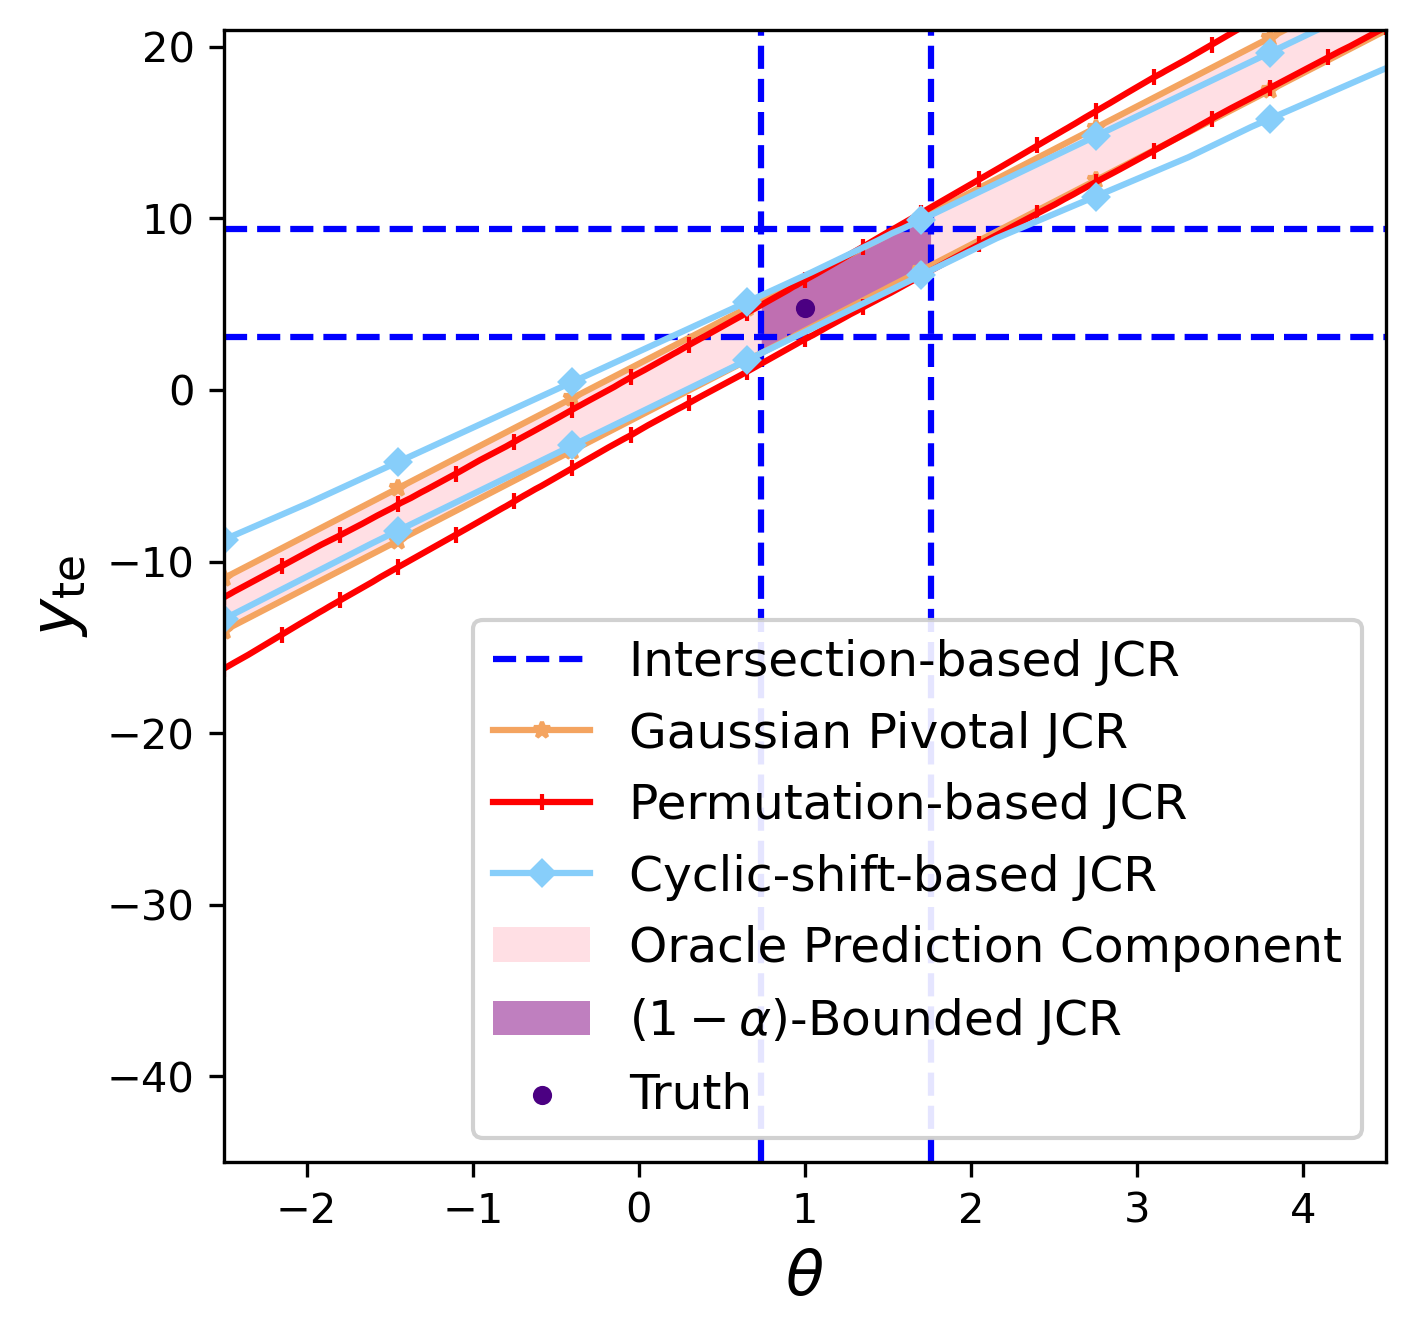

In [103]:
fig, ax = plt.subplots(dpi=300,figsize=(5,5))

vline_indx = [theta_u_cl, theta_l_cl]
hline_indx = [y_pred_l_cl, y_pred_u_cl]

plt.vlines(vline_indx, -45, 21,colors='b', linestyles='dashed',label='Intersection-based JCR')
plt.hlines(hline_indx, -2.5, 4.5,colors='b', linestyles='dashed')

ax.plot(thetagrid, pred_cl_l, linewidth=1.5,c='sandybrown',label='Gaussian Pivotal JCR',marker='*',markevery=150,markersize=4)
ax.plot(thetagrid, pred_cl_u, linewidth=1.5,c='sandybrown',marker='*',markevery=150,markersize=4)

ax.plot(thetagrid, pred_pb_l, linewidth=1.5,c='red',label='Permutation-based JCR',marker='|',markevery=50,markersize=4)
ax.plot(thetagrid, pred_pb_u, linewidth=1.5,c='red',marker='|',markevery=50,markersize=4)

ax.plot(thetagrid, pred_cb_u, linewidth=1.5,c='lightskyblue',marker='D',markevery=150,markersize=4,label='Cyclic-shift-based JCR')
ax.plot(thetagrid, pred_cb_l, linewidth=1.5,c='lightskyblue',marker='D',markevery=150,markersize=4)

ax.fill_between(thetagrid, pred_ot_l, pred_ot_u, alpha=.5, linewidth=0,color='pink',label='Oracle Prediction Component')

ax.fill_between(thetagrid1, intersect_l, intersect_u, alpha=.5, linewidth=0,color='purple',label='$(1-α)$-Bounded JCR')
plt.scatter(1,float(yte),c='indigo',s=13,label='Truth')

plt.ylabel('$y_{\mathrm{te}}$',size=15)
plt.xlabel('$θ$',size=15)
plt.xlim(-2.5,4.5)
plt.ylim(-45,21)
plt.legend(loc='lower right',fontsize=11.7,framealpha=0.9)
# plt.savefig('jcrs_compare.png',bbox_inches = 'tight')
plt.savefig('jcrs_compare_50.png',bbox_inches = 'tight')
plt.show()